In [4]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score

from scipy.stats.mstats import winsorize 
from scipy.stats import pointbiserialr, zscore, chi2_contingency
import itertools
from collections import OrderedDict 





Этот notebook представляет собой исследование основных закономерностей, присутствующих в обучающем датасете train.csv Его задачей является поиск значимых корреляций между независимыми признаками и целевой переменной, подготовка данных к анализу, конструирование новых признаков. Результаты этого исследования будет использованы при построении модели и её обучении.

Для того чтобы понять какие действия нам необходимо предпринять, мы начнём с анализа данных в обучающем сете и поймём как из них можно извлечь побольше информации. После этого мы объединим тестовый и тренировочный сеты для совместной обработки согласно сформулированнм правилам обработки. Сделаем мы это в отдельном ноутбуке

In [5]:
#модуль оценки значимости корреляций Phi.

def fik(dataframe):
    dataframe=pd.concat([dataframe, train['default']], axis=1)
    significance_overview = dataframe.significance_matrix()
    plot_correlation_matrix(significance_overview.fillna(0).values, x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index,  title='significance', 
                        usetex=False, fontsize_factor=1.5, figsize=(20,25))
    plt.tight_layout()

In [6]:
# #Таблица метрик для сравнения результатов каждой модели
# metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
# summary = pd.DataFrame(index = metrics)
# def summary_metrics(summary,col,y_valid,y_pred,y_pred_probs):
#     values = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred), f1_score(y_valid,y_pred), roc_auc_score(y_valid, y_pred_probs)]
#     summary[col] = values
#     return summary

# кривая ROC_AUC 
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_yest, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

# Confusion matrix
def conf_mat(y_valid, y_pred):
    P = np.sum(y_valid==1)
    N = np.sum(y_valid==0)
    print('Positive: {0}, Negative: {1}'.format(P,N))
    
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print(tp, fp) 
    print(fn, tn)

Data Description Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

Описания полей client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [7]:
# программа поиска отношения значений у соседствующих значений недефолт-деволт
def ratio(df, digs=2):
    z=round(df[1]/df[0], digs)
    return z

In [8]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

Для начала рассмотрим обучающий и тестовый датасеты и попытаемся понять, насколько сильно они между собой различаются.

In [9]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

Проверим датасет на наличие пропусков

In [10]:
pd.concat([train.isna().sum(), test.isna().sum()], axis=1).rename(columns={0:'Train', 1:'Test'})

,Train,Test
client_id,0,0.0
app_date,0,0.0
education,307,171.0
sex,0,0.0
age,0,0.0
car,0,0.0
car_type,0,0.0
decline_app_cnt,0,0.0
good_work,0,0.0
score_bki,0,0.0


Итак, среди признаков, только один признак Education содержит пропуски в количестве 307 записей в обучающей и 171 запись в тестовой части. В разделе конструирование признаков мы проведём иследование этой переменной и определимся со стратегией замены.

А пока посмотрим сколько у нас невозвратов по кредитам в тренировочном сете.

In [11]:
train['default'].value_counts(normalize=True)

0    0.873006
1    0.126994
Name: default, dtype: float64

Посмотрим теперь как у нас какой тип имеют данные в наших датафреймах, сколько значений принимают признаки, и имеются ли преобладающие значения признаков.

In [13]:
for dataset in [train, test]:
#     display(dataset.head()) 
    for col in dataset.columns: 
        display(f' {col :<20} {dataset[col].nunique() :<10}{dataset[col].value_counts(normalize=True).max() :<10} {dataset[col].dtypes}')
#         if dataset[col].value_counts(normalize=True).max()>0.20:
            
    print('____________________________________________________')

' client_id            73799     1.3550319110015041e-05 int64'

' app_date             120       0.013794224853995311 object'

' education            5         0.5287650356501388 object'

' sex                  2         0.5631783628504451 object'

' age                  52        0.03695172021301102 int64'

' car                  2         0.6752395018902695 object'

' car_type             2         0.8101871299069093 object'

' decline_app_cnt      21        0.8294692340004607 int64'

' good_work            2         0.835106166750227 int64'

' score_bki            69096     0.004769712326725294 float64'

' bki_request_cnt      38        0.2626187346712015 int64'

' region_rating        7         0.37294543286494397 int64'

' home_address         3         0.541416550359761 int64'

' work_address         3         0.6092087968671662 int64'

' income               966       0.09497418664209542 int64'

' sna                  4         0.6409436442228215 int64'

' first_time           4         0.4235152237835201 int64'

' foreign_passport     2         0.8500521687285736 object'

' default              2         0.8730064093009391 int64'

____________________________________________________


' client_id            36349     2.7511073206965803e-05 int64'

' app_date             120       0.013012737626894826 object'

' education            5         0.5289955221405274 object'

' sex                  2         0.5577594981980247 object'

' age                  51        0.03733252634185259 int64'

' car                  2         0.6728658284959697 object'

' car_type             2         0.8074224875512394 object'

' decline_app_cnt      19        0.8324025420231643 int64'

' good_work            2         0.8332278742193733 int64'

' score_bki            34287     0.004566838152356323 float64'

' bki_request_cnt      34        0.2620979944427632 int64'

' region_rating        7         0.3702440232193458 int64'

' home_address         3         0.5401799224187736 int64'

' work_address         3         0.6094803158271204 int64'

' income               685       0.09430795895347878 int64'

' sna                  4         0.6432088915788605 int64'

' first_time           4         0.42182728548240667 int64'

' foreign_passport     2         0.8525131365374563 object'

____________________________________________________


Исходя из сходства частот преобладающих значений независимых признаков для обеих сетов, мы можем предположить что сеты образуют весьма однородную совокупность и тенденции наблюдаемые в первом сете, скорее всего будут проявляться и во втором.

Итак, какие данные имеются в нашем распоряжении?

В датасете присутствуют 13 численных (12 int64 и 1 float64) и 6 категориальных признаков. Численный признак default является нашей целевой переменной.

По своему типу данны подразделяются на:

Номинальные:
Бинарные:
sex
car
car_type
foreign_passport
default
good_work
Тринарные:
home_address
work_address
Ординальные:
education
sna
Относительные:

client_id
age
decline_app_cnt
bki_request_cnt
region_rating
income

first_time

Посмотрим, имеются ли у нас межпризнаковые корреляции и кореляции признаков с целевой переменной default

In [14]:
train.corr(method='kendall').default.sort_values(ascending=False)

default            1.000000
score_bki          0.140014
sna                0.117971
decline_app_cnt    0.116654
home_address       0.087258
work_address       0.079038
bki_request_cnt    0.067042
age               -0.022108
client_id         -0.032073
good_work         -0.043361
income            -0.049028
region_rating     -0.077723
first_time        -0.097052
Name: default, dtype: float64

Корреляция независимых признаков с целевой переменной слабая, самую тесную положительную связь демонстрируют score_bki, sna, decline_app_cnt, а самую тесную отрицательную- first_time.

Проведём раздельную предобработку данных и конструирование признаков.

# 1. Работа с бинарными данными
Отберём все бинарные данные и изучим их

In [15]:
bin_cols=train.columns[train.apply(pd.Series.nunique).values==2]

In [16]:
bins=train[bin_cols]

In [17]:
bins.head()

,sex,car,car_type,good_work,foreign_passport,default
0,M,Y,Y,0,N,0
1,F,N,N,0,N,0
2,M,Y,N,0,Y,0
3,F,N,N,0,N,0
4,M,N,N,1,Y,0


In [18]:
bins=pd.concat([bins, pd.get_dummies(bins.select_dtypes(exclude='int64'), 
                                     drop_first=True, dtype='float64' )], 
               axis=1).select_dtypes(exclude='object')

Векторизируем наши переменные и проверим насколько коррелированы будут переменные. При векторизации будем убирать одну из получившихся при разбиении переменных, а также исходные категориальные параметры.

In [19]:
bins.corr(method='kendall').round(3)

,good_work,default,sex_M,car_Y,car_type_Y,foreign_passport_Y
good_work,1.000,-0.043,-0.040,0.002,0.018,0.046
default,-0.043,1.000,0.020,-0.043,-0.057,-0.067
sex_M,-0.040,0.020,1.000,0.279,0.226,0.086
car_Y,0.002,-0.043,0.279,1.000,0.698,0.108
car_type_Y,0.018,-0.057,0.226,0.698,1.000,0.146
foreign_passport_Y,0.046,-0.067,0.086,0.108,0.146,1.000


Обратим внимание на коэффициенты корреляции независимых признаков между собой. и целевой переменной

In [20]:
bin_cols=bins.columns # количество ппризнаков у нас увеличилось соответственно обновляем их список

In [21]:
bins.dtypes

good_work               int64
default                 int64
sex_M                 float64
car_Y                 float64
car_type_Y            float64
foreign_passport_Y    float64
dtype: object

Из данных корреляции видно что корреляции бинарных признаков с целевой переменной по модулю не превышают значений 0,067. Попробуем сконструировать критерий с более высокой степенью корреляции. Для этого: 1) построим кросстабуляции бинарных признаков протв целевой переменной.

2) оценим отношения дефолт/недефолт для каждого из бинарных значений. После этого считаем их отношения и вычитаем из результата единицу, полученный коэффициент далее будем называть коэффициентом преобладания. Более высокие значения коэффициента соответствуют более высоким значениям корреляции.

3) Осуществим отбор переменных имеющих максимальные значения нашего коэффициента (от большего к меньшему) и их аггрегирование в единый параметр с попутной проверки корреляции с целевой переменной.

In [22]:
bins['fp']=np.where((bins['foreign_passport_Y']==0), 0.0, 1.0)
bins['fp'].corr(bins['default'], method='kendall')

-0.0667181142401042

In [23]:
bins['fp_ct']=np.where((bins['foreign_passport_Y']==0)
                       & (bins['car_type_Y']==0), 0.0, 1.0) 
bins['fp_ct'].corr(bins['default'], method='kendall')

-0.07743386426794659

In [24]:
bins['fp_ct_gw']=np.where((bins['foreign_passport_Y']==0)
                          & (bins['car_type_Y']==0) 
                          & (bins['good_work']==0), 0.0, 1.0) 
bins['fp_ct_gw'].corr(bins['default'], method='kendall')

-0.08346744841847348

Итак, из трёх бинарных категориальных признаков мы создали один признак комбинации сочетания следующих свойств: Отсутствие паспорта, машины и оценки в качестве хорошего работника, который демонстрирует слабое отрицательное влиение на риск дефолта.

Этому признаку мы и доверим представлять бинарные данные в нашей модели.

In [25]:
# bins=bins[['fp_ct_gw', 'foreign_passport_Y', 'car_type_Y']]

# Тринарные признаки

In [26]:
trin_cols=train.columns[train.apply(pd.Series.nunique).values==3]
trins=train[trin_cols]
#для векторизации меняем тип данных с int64 на float64

Двигаемся дальше. Вспоминаем наши тринарные категориальные переменные и также подвергнем их преобразованию. Мы попробуем рассмотретиь их в качестве порядковой шкалы (предполагая наличие какой-то связи номера и верояности дефолта, к примеру номер зоны характеризующей расстояние от центра города и т. п.), а также подвергнуть векторизации чтобы понять насколько тесно они сами по себе (абстрагируясь от присвоенного кода) коррелируют с регрессиией.

Преобразуем наши переменные. для начала соберём все бинарные данные
Здесь мы попытаемся понять, несёт ли какую-то смысловую нагрузку кодификация адресов работы и проживания. Поэтому мы не будем удалять исходные столбцы до сопоставления.

По результатам сопоставления мы выберем тринарные признаки которые будем использовать в нашей модели.

In [27]:
trins=pd.concat([trins, pd.get_dummies(trins.astype('object'), dtype='float64')], axis=1)
trins.head()

,home_address,work_address,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3
0,1,2,1.0,0.0,0.0,0.0,1.0,0.0
1,2,3,0.0,1.0,0.0,0.0,0.0,1.0
2,1,2,1.0,0.0,0.0,0.0,1.0,0.0
3,2,3,0.0,1.0,0.0,0.0,0.0,1.0
4,2,3,0.0,1.0,0.0,0.0,0.0,1.0


In [28]:
trins.corrwith(train.default, method='spearman').sort_index()

home_address      0.087961
home_address_1   -0.091058
home_address_2    0.091869
home_address_3   -0.004325
work_address      0.082000
work_address_1   -0.056622
work_address_2   -0.045619
work_address_3    0.078609
dtype: float64

Мы видим что:

1) для домашних адресов 1 и 2 мы имеем слабые корреляции с целевой переменной (отрицательную и положительную) причём их связь с ней тесне чем у исходного категориального признака при его восприятии в качестве порядковой шкалы. Следовательно для этих адресов важнее скрытые признаки не отражённые упорядочиванием.

2) рабочие адреса ведут себя по другому, у них порядковая переменная связана с целевой переменной теснее, хотя рабочий адрес 3 практически дотягивает до значения корреляции для исходного порядкового признака. При этом отсутствуют векторизированны признаки близкие к нулю (как home_3). Возможно присутствует какая-то географическая либо иная закономерность позволяющяя качественно их сравнивать.

Посмотрим как распределены наши значения для исходных тринарных признаков

In [29]:
a=trins[['home_address', 'work_address']].apply(pd.value_counts, normalize=True).round(2).T*100
a

,1,2,3
home_address,44.0,54.0,2.0
work_address,11.0,28.0,61.0


Рассмотрим комбинацию "рабочий адрес2- домашний адрес 3", которая преобладала в наших подсетах для дефолтников и недефолтников.

In [30]:
trin_cols=trins.columns

In [31]:
trins['adresses_h2w3']=np.where((trins['home_address']==2) & (trins['work_address']==3), 1.0, 0.0) 
print(trins[['adresses_h2w3']].corrwith(train['default'], method='kendall').round(3))
trins.corrwith(trins.adresses_h2w3, method='kendall').sort_index()

adresses_h2w3    0.094
dtype: float64


adresses_h2w3     1.000000
home_address      0.879803
home_address_1   -0.932101
home_address_2    0.964762
home_address_3   -0.138046
work_address      0.789189
work_address_1   -0.374023
work_address_2   -0.650253
work_address_3    0.839588
dtype: float64

# квартенарные переменные

С квартенарным признаками мы поступим аналогично тринарным.

In [32]:
quart_cols=train.columns[train.apply(pd.Series.nunique).values==4]
quartins=train[quart_cols]

Проведём оценку их коррелированности с целевой переменной, кросс-табуляцю и векторизацию

In [33]:
quartins.apply(pd.value_counts, normalize='index').round(2).T*100

,1,2,3,4
sna,64.0,14.0,6.0,16.0
first_time,17.0,16.0,42.0,25.0


In [34]:
quartins.corrwith(train.default, method='kendall').sort_index()

first_time   -0.097052
sna           0.117971
dtype: float64

In [35]:
quartins=pd.concat([quartins, pd.get_dummies(quartins.astype('object'), dtype='float64')], axis=1)
quartins.head()

,sna,first_time,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,4,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,4,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
quartins.corrwith(train.default, method='kendall').sort_index()

first_time     -0.097052
first_time_1    0.079187
first_time_2    0.036820
first_time_3   -0.017311
first_time_4   -0.078774
sna             0.117971
sna_1          -0.115534
sna_2           0.028118
sna_3           0.022398
sna_4           0.110448
dtype: float64

Векторизация результатов не дала, векторизированные компоненты связаны с целевой фунцией слабее, хотя sna_1 практически дотягивается до значения корреляции исходного признака.

Посмотри как все получившиеся признаки между собой коррелируют

In [37]:
quartins.corr().round(2)

,sna,first_time,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
sna,1.00,-0.53,-0.87,0.10,0.27,0.88,0.52,0.05,-0.17,-0.29
first_time,-0.53,1.00,0.49,-0.12,-0.13,-0.45,-0.78,-0.33,0.20,0.71
sna_1,-0.87,0.49,1.00,-0.55,-0.33,-0.58,-0.42,-0.12,0.13,0.31
sna_2,0.10,-0.12,-0.55,1.00,-0.10,-0.18,0.00,0.14,0.02,-0.14
sna_3,0.27,-0.13,-0.33,-0.10,1.00,-0.11,0.06,0.11,-0.03,-0.11
sna_4,0.88,-0.45,-0.58,-0.18,-0.11,1.00,0.50,-0.04,-0.17,-0.20
first_time_1,0.52,-0.78,-0.42,0.00,0.06,0.50,1.00,-0.19,-0.38,-0.26
first_time_2,0.05,-0.33,-0.12,0.14,0.11,-0.04,-0.19,1.00,-0.37,-0.25
first_time_3,-0.17,0.20,0.13,0.02,-0.03,-0.17,-0.38,-0.37,1.00,-0.50
first_time_4,-0.29,0.71,0.31,-0.14,-0.11,-0.20,-0.26,-0.25,-0.50,1.00


Мы видим, что параметры sna и first_time имеют высокий уровень отрицательной корреляции. Попробуем агрегировать их и провести бинаризацию. Проводим кросстабуляцию и смотрим на преобладающие сочетания значений признаков. К таколвым у нас относится комбинация sna=1 и first_time=3 или 4.

In [38]:
round(pd.crosstab(quartins.sna, quartins.first_time, normalize=True)*100, 1)

first_time,1,2,3,4
sna,,,,
1,3.2,7.9,30.2,22.8
2,2.4,4.0,6.5,1.4
3,1.5,1.8,2.0,0.3
4,9.5,2.0,3.6,0.8


In [39]:
quartins['sna_ft']=np.where((quartins['sna']==1) & (quartins['first_time']>2), 0.0, 1.0)
quartins[['sna_ft']].corrwith(train['default'], method='kendall')

sna_ft    0.121832
dtype: float64

In [40]:
quartins[['sna', 'first_time']].corrwith(quartins['sna_ft'], method='kendall')

sna           0.734102
first_time   -0.645339
dtype: float64

полученный нами признак превосходит исходные параметры постепени корреляции с целевой переменной, а также более коррелирован с ними чем сами они между собой. Мы берём его в модель

# Пятиуровневая переменная Education
Порядковый признак Education принимает 5 уровней, самый низкий из которых SCH соответствует школьному образованию, а самый высокий- учёной степени PhD. Для оценки перспективности посмотрим как распределён показатель, заполним пропуски, перекодируем его, а также проведём векторизацию, после чего сравним степень их корреляции с целевой переменной.

Смотрим как распределён признак

In [41]:
pd.concat([train.education.value_counts(dropna=False), 
           train.education.value_counts(dropna=False,
                                        normalize=True).round(4)*100], axis=1)

,education,education
SCH,38860,52.66
GRD,23365,31.66
UGR,9816,13.30
PGR,1257,1.70
NaN,307,0.42
ACD,194,0.26


Смотрим как распределены по уровням образования соответствующие частоты дефолтов

In [42]:
train['default'].groupby(train['education'], 
                         dropna=False).apply(pd.value_counts, 
                                             normalize=True).unstack().round(4)*100

,0,1
education,,
ACD,95.88,4.12
GRD,90.99,9.01
PGR,93.56,6.44
SCH,84.94,15.06
UGR,86.85,13.15
NaN,88.60,11.40


Для отсутствующих данных, частота невозврата занимает промежуточное положение между частотами невозврата для имеющих степень бакалавра и степень магистра.

Поскольку в нашем датасете доля группы заёмщиков UGR меньше доли группы заёмщиков GRD (32 и 13% соответственно), представляется логичным отнести заёмщиков с неизвестным уровнем образования к более крупной группе GRD, что мы и сделаем

In [43]:
train.education.fillna('GRD', inplace=True)

Вклад наблюдений с отсутствующим образованием незначителен (0,42%), и в принципе мы могли бы удалить эти данные. Но с другой стороны датасет вполне однородный и эти наблюдения можно оставить заменив их значениями одного из соседних уровней образования.

In [44]:
train.default.groupby(train['education'], dropna=False).value_counts(normalize=True).round(4).unstack().sort_values(
    by=0, ascending=False)*100

default,0,1
education,,
ACD,95.88,4.12
PGR,93.56,6.44
GRD,90.96,9.04
UGR,86.85,13.15
SCH,84.94,15.06


Мы пришли к выводу о том что самыми надёжными заёмщиками в нашей выборке предсказуемо оказались лица с научными степенями, в то время заёмщики имеющие школьное образование и закончившие бакалавриат имели максимальный риск невозврата.

Проведём векторизацию, а далее отранжируем уровни образования согласно наблюдаемым частотам дефолта.

In [45]:
pents=pd.concat([train['education'], pd.get_dummies(train['education'], dtype='float64')], axis=1)

Корреляции векторизированных признаков образования с целевой переменной невысоки (в районе 0,075 по модулю для значений SCH и GRD). Проведём кодирование

In [46]:
pents['education'].replace({'SCH':4.0, 'UGR':3.0, 'GRD':2.0, 'PGR':1.0, 'ACD':0.0}, inplace=True)

In [47]:
# pents=pd.concat([pents, coder], axis=1)
# drop('education', axis=1).astype('float')
pents.columns

Index(['education', 'ACD', 'GRD', 'PGR', 'SCH', 'UGR'], dtype='object')

In [48]:
a=pents.corrwith(train['default'])

In [49]:
pents.dtypes

education    float64
ACD          float64
GRD          float64
PGR          float64
SCH          float64
UGR          float64
dtype: object

In [50]:
pents[["education"]].corrwith(train['default'])

education    0.084806
dtype: float64

In [51]:
b=pents.corrwith(pents['education'])

# Семииуровневая переменная region rating
Проделываем аналогичные операции

In [52]:
pd.concat([train.region_rating.value_counts(dropna=False),
           train.region_rating.value_counts(dropna=False, 
                                            normalize=True).round(4)*100], axis=1)

,region_rating,region_rating
50,27523,37.29
60,16075,21.78
40,12027,16.30
80,11469,15.54
70,6199,8.40
30,300,0.41
20,206,0.28


Распределение регионов по рейтингу близкое к нормальному.

Посмотрим как распределены по регионам дефолты

In [53]:
train.default.groupby(train['region_rating'], 
                      dropna=False).value_counts(normalize=True).round(4).unstack().sort_values(by=0,
                                                                                                ascending=False)*100

default,0,1
region_rating,,
80,92.68,7.32
70,90.76,9.24
60,87.12,12.88
50,86.39,13.61
40,83.03,16.97
30,81.00,19.00
20,78.64,21.36


Между рейтингом и количеством невозвратов прослеживается обратная связь, скорее всего рейтинги определяют надёжность жителей региона в качестве заёмщиков. Посмотрим какова корреляция этого признака с целевым.

In [54]:
hepts=pd.concat([train['region_rating'], pd.get_dummies(train['region_rating'], dtype='float64')], axis=1)
hepts.corrwith(train['default'])

region_rating   -0.089035
20               0.013760
30               0.012089
40               0.056597
50               0.021186
60               0.002916
70              -0.031431
80              -0.069362
dtype: float64

В модели будем использовать упорядоченный рейтинг.

In [55]:
hepts=hepts['region_rating']

Соберём в единый датафрейм все признаки которые мы рассмотрели

In [56]:
X_low=pd.concat([bins, trins, quartins, pents, hepts], axis=1)

In [57]:
X_low.head()

,good_work,default,sex_M,car_Y,car_type_Y,foreign_passport_Y,fp,fp_ct,fp_ct_gw,home_address,work_address,home_address_1,home_address_2,home_address_3,work_address_1,...,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,sna_ft,education,ACD,GRD,PGR,SCH,UGR,region_rating
0,0,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1,2,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,50
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,0.0,50
2,0,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1,2,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,80
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,50
4,1,0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,60


проведём нормализацию параметров education и region_rating.

In [58]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
mms=MinMaxScaler()

In [60]:
X_low[['education', 'region_rating']] = mms.fit_transform(X_low[['education', 'region_rating']])

In [61]:
X_low.corr()

,good_work,default,sex_M,car_Y,car_type_Y,foreign_passport_Y,fp,fp_ct,fp_ct_gw,home_address,work_address,home_address_1,home_address_2,home_address_3,work_address_1,...,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,sna_ft,education,ACD,GRD,PGR,SCH,UGR,region_rating
good_work,1.000000,-0.043361,-0.040247,0.002027,0.017521,0.046361,0.046361,0.033786,0.541828,-0.003624,-0.008535,0.004775,-0.005679,0.003544,0.029394,...,-0.020611,-0.020487,-0.040156,-0.046058,-0.016622,0.014429,0.036863,-0.057790,-0.178534,0.042083,0.151503,0.048745,-0.161683,0.004559,0.073041
default,-0.043361,1.000000,0.019619,-0.043161,-0.057484,-0.066718,-0.066718,-0.077434,-0.083467,0.084637,0.081582,-0.091058,0.091869,-0.004325,-0.056622,...,0.028118,0.022398,0.110448,0.079187,0.036820,-0.017311,-0.078774,0.121832,0.084806,-0.013223,-0.075520,-0.024730,0.074744,0.005325,-0.089035
sex_M,-0.040247,0.019619,1.000000,0.279488,0.225578,0.086326,0.086326,0.207091,0.138339,0.037607,0.068967,-0.036522,0.032971,0.013186,-0.059426,...,0.006407,-0.002857,-0.004497,-0.017648,0.008254,-0.001153,0.009495,-0.000635,-0.041018,0.016143,0.024790,0.017084,-0.041469,0.017953,0.107711
car_Y,0.002027,-0.043161,0.279488,1.000000,0.697939,0.107568,0.107568,0.532017,0.409521,-0.025240,-0.007523,0.027078,-0.027243,0.000995,-0.006176,...,-0.008811,-0.016629,-0.064032,-0.077856,-0.022669,0.025393,0.056641,-0.073078,-0.139420,0.023733,0.110177,0.066591,-0.121888,-0.001180,0.064685
car_type_Y,0.017521,-0.057484,0.225578,0.697939,1.000000,0.145807,0.145807,0.755733,0.590201,-0.012032,0.000506,0.013287,-0.013742,0.001926,-0.002173,...,-0.012200,-0.020100,-0.075566,-0.088267,-0.024782,0.023385,0.069584,-0.085283,-0.184836,0.030486,0.150997,0.087431,-0.157727,-0.013554,0.104110
foreign_passport_Y,0.046361,-0.066718,0.086326,0.107568,0.145807,1.000000,1.000000,0.655761,0.512126,0.038658,0.041769,-0.044411,0.047582,-0.012794,-0.002958,...,-0.010956,-0.041022,-0.157757,-0.147270,-0.036600,-0.010955,0.168862,-0.163249,-0.181605,0.034771,0.151357,0.062922,-0.162594,0.001801,0.255456
fp,0.046361,-0.066718,0.086326,0.107568,0.145807,1.000000,1.000000,0.655761,0.512126,0.038658,0.041769,-0.044411,0.047582,-0.012794,-0.002958,...,-0.010956,-0.041022,-0.157757,-0.147270,-0.036600,-0.010955,0.168862,-0.163249,-0.181605,0.034771,0.151357,0.062922,-0.162594,0.001801,0.255456
fp_ct,0.033786,-0.077434,0.207091,0.532017,0.755733,0.655761,0.655761,1.000000,0.780965,0.009700,0.019824,-0.012165,0.013976,-0.007130,-0.000965,...,-0.011893,-0.035636,-0.148629,-0.150415,-0.035037,0.012221,0.143933,-0.152377,-0.227511,0.031796,0.191831,0.087933,-0.200525,-0.007145,0.212412
fp_ct_gw,0.541828,-0.083467,0.138339,0.409521,0.590201,0.512126,0.512126,0.780965,1.000000,-0.002347,0.000256,0.002000,-0.001502,-0.001893,0.021893,...,-0.014477,-0.038257,-0.138039,-0.141806,-0.033576,0.019394,0.127212,-0.144879,-0.263713,0.038313,0.223503,0.089603,-0.237300,0.001774,0.190566
home_address,-0.003624,0.084637,0.037607,-0.025240,-0.012032,0.038658,0.038658,0.009700,-0.002347,1.000000,0.728139,-0.969865,0.874173,0.355534,-0.362887,...,-0.029653,-0.014964,0.133674,0.087369,-0.013456,-0.058032,0.002460,0.063555,-0.001400,0.007198,-0.006792,-0.000479,-0.007061,0.018816,0.233820


На этом мы заколнчили подготовку 2-7 мерных признаков. Далее мы будем обрабатывать количественные признаки боольшей размерности

# Признаки размерности 8+
Итак, перед нами оставшиеся 7 признаков, среди которых один временной ряд. Посмотрим их описания

In [62]:
high_cols=train.columns[train.apply(pd.Series.nunique).values>7]
high_cols

Index(['client_id', 'app_date', 'age', 'decline_app_cnt', 'score_bki',
       'bki_request_cnt', 'income'],
      dtype='object')

In [63]:
highs=train[high_cols]
highs.head(2)

,client_id,app_date,age,decline_app_cnt,score_bki,bki_request_cnt,income
0,25905,01FEB2014,62,0,-2.008753,1,18000
1,63161,12MAR2014,59,0,-1.532276,3,19000


In [64]:
highs.describe().round(2)

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,income
count,73799.00,73799.00,73799.00,73799.00,73799.00,73799.00
mean,55137.97,39.28,0.28,-1.90,2.00,41099.78
std,31841.92,11.52,0.80,0.50,2.25,46166.32
min,1.00,21.00,0.00,-3.62,0.00,1000.00
25%,27440.50,30.00,0.00,-2.26,0.00,20000.00
50%,55274.00,37.00,0.00,-1.92,1.00,30000.00
75%,82758.50,48.00,0.00,-1.57,3.00,48000.00
max,110147.00,72.00,33.00,0.20,53.00,1000000.00


In [65]:
highs.corr()

,client_id,age,decline_app_cnt,score_bki,bki_request_cnt,income
client_id,1.000000,0.015435,-0.021417,-0.063293,-0.029028,-0.000099
age,0.015435,1.000000,-0.111175,-0.106275,0.046265,-0.018900
decline_app_cnt,-0.021417,-0.111175,1.000000,0.189987,0.155894,-0.021687
score_bki,-0.063293,-0.106275,0.189987,1.000000,0.156257,-0.012639
bki_request_cnt,-0.029028,0.046265,0.155894,0.156257,1.000000,0.082983
income,-0.000099,-0.018900,-0.021687,-0.012639,0.082983,1.000000


array([[<AxesSubplot:title={'center':'client_id'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'decline_app_cnt'}>,
        <AxesSubplot:title={'center':'score_bki'}>],
       [<AxesSubplot:title={'center':'bki_request_cnt'}>,
        <AxesSubplot:title={'center':'income'}>]], dtype=object)

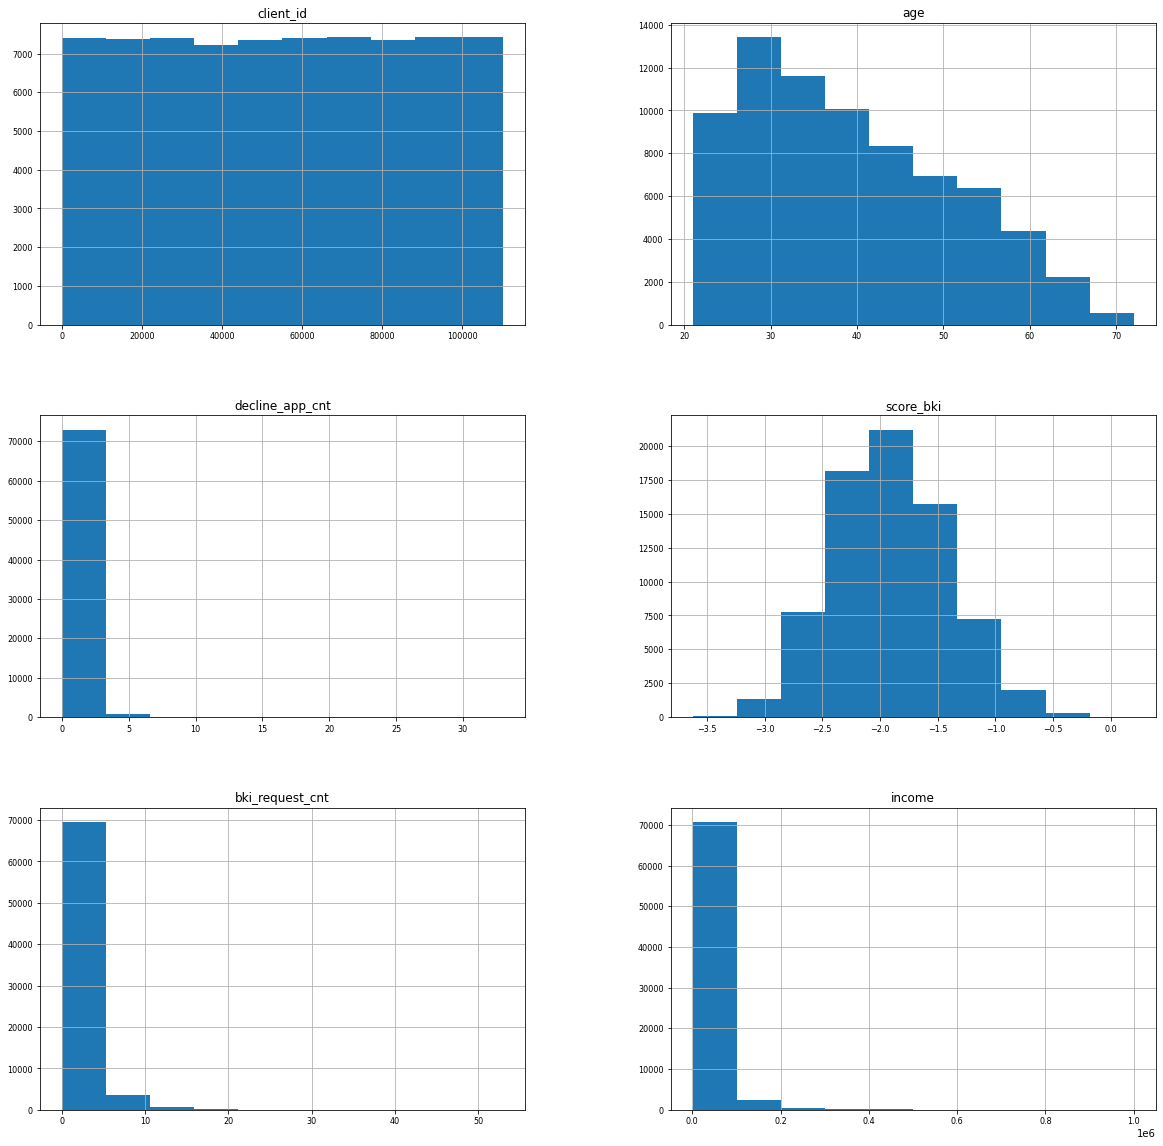

In [66]:
highs.hist(xlabelsize=8, ylabelsize=8, figsize=(20, 20) )

In [67]:
towins_cols=['decline_app_cnt', 'score_bki',
       'bki_request_cnt', 'income']

In [68]:
towins=highs[towins_cols]

In [69]:
for col in towins_cols:
    towins[col]=winsorize(towins[col], limits = 0.005)
towins.corrwith(train['default'])

<ipython-input-69-fb01b24b4048>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  towins[col]=winsorize(towins[col], limits = 0.005)


decline_app_cnt    0.119740
score_bki          0.175260
bki_request_cnt    0.078140
income            -0.047169
dtype: float64

In [70]:
highs.corrwith(train['default'])

client_id         -0.039242
age               -0.025004
decline_app_cnt    0.113682
score_bki          0.175369
bki_request_cnt    0.078242
income            -0.039752
dtype: float64

Отмечается слабое влияние на целевую переменную признаков score_bki, decline_app_cnt и bki_request_cnt

In [71]:
highs['decline_app_cnt_om']=np.log10(highs['decline_app_cnt']+1)
highs[['decline_app_cnt_om']].corrwith(train['default'])

<ipython-input-71-81d9362d2c66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['decline_app_cnt_om']=np.log10(highs['decline_app_cnt']+1)


decline_app_cnt_om    0.124027
dtype: float64

In [72]:
highs[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt']]=mms.fit_transform(highs[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt']])

<ipython-input-72-3b982a025649>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt']]=mms.fit_transform(highs[['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt']])
C:\Users\777\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [73]:
highs['income']=np.log10(highs[['income']]+1)
highs[['income']].corrwith(train['default'])

<ipython-input-73-73baebbfd826>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['income']=np.log10(highs[['income']]+1)


income   -0.053871
dtype: float64

В корреляционное сопоставление попал один из наших признаков- временной ряд 'app_date'. Для того чтобы извлечь необходимую нам информацию, осуществим преобразование этого параметра

In [74]:
highs['app_date'] = pd.to_datetime(highs.app_date)

<ipython-input-74-6b153b31cfec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['app_date'] = pd.to_datetime(highs.app_date)


In [75]:
highs['app_date'].head()

0   2014-02-01
1   2014-03-12
2   2014-02-01
3   2014-01-23
4   2014-04-18
Name: app_date, dtype: datetime64[ns]

In [76]:
highs['app_monthday']= highs['app_date'].apply(lambda x: x.day).astype('float64')

<ipython-input-76-c70efd4bbacc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['app_monthday']= highs['app_date'].apply(lambda x: x.day).astype('float64')


In [77]:
highs['month']=highs['app_date'].dt.month.astype('int64')

<ipython-input-77-b32ec6976c81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['month']=highs['app_date'].dt.month.astype('int64')


In [78]:
highs['app_weekday']=highs['app_date'].dt.weekday.astype('float64')
highs[['app_weekday']].head()

<ipython-input-78-53f8cfa2903d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['app_weekday']=highs['app_date'].dt.weekday.astype('float64')


,app_weekday
0,5.0
1,2.0
2,5.0
3,3.0
4,4.0


In [79]:
highs['app_week']=highs['app_date'].dt.isocalendar().week.astype('float64')
highs['app_week'].head()

<ipython-input-79-2804b316af02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['app_week']=highs['app_date'].dt.isocalendar().week.astype('float64')


0     5.0
1    11.0
2     5.0
3     4.0
4    16.0
Name: app_week, dtype: float64

In [80]:
highs['app_week']

0         5.0
1        11.0
2         5.0
3         4.0
4        16.0
         ... 
73794    10.0
73795    13.0
73796    17.0
73797     1.0
73798     4.0
Name: app_week, Length: 73799, dtype: float64

In [81]:
highs.dtypes

client_id                      int64
app_date              datetime64[ns]
age                          float64
decline_app_cnt              float64
score_bki                    float64
bki_request_cnt              float64
income                       float64
decline_app_cnt_om           float64
app_monthday                 float64
month                          int64
app_weekday                  float64
app_week                     float64
dtype: object

In [82]:
ratio(train.default.groupby(highs['app_week']).value_counts().unstack(), 3)

app_week
1.0     0.164
2.0     0.189
3.0     0.154
4.0     0.162
5.0     0.164
6.0     0.154
7.0     0.152
8.0     0.150
9.0     0.156
10.0    0.154
11.0    0.143
12.0    0.146
13.0    0.142
14.0    0.148
15.0    0.122
16.0    0.102
17.0    0.102
18.0    0.107
dtype: float64

In [83]:
highs['app_week_bin']=np.where(highs['app_week']<15, 1, 0)
highs[['app_week_bin']].corrwith(train['default'])

<ipython-input-83-84be320ee921>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['app_week_bin']=np.where(highs['app_week']<15, 1, 0)


app_week_bin    0.040581
dtype: float64

In [84]:
highs[['app_week_bin']].corrwith(highs['app_week'])

app_week_bin   -0.669764
dtype: float64

In [85]:
np.log(highs[['app_week_bin']].corrwith(train['default']))

app_week_bin   -3.20446
dtype: float64

In [86]:
highs.corrwith(train['default']).abs().sort_values(ascending=False)

score_bki             0.175369
decline_app_cnt_om    0.124027
decline_app_cnt       0.113682
bki_request_cnt       0.078242
income                0.053871
app_week_bin          0.040581
app_week              0.039276
client_id             0.039242
month                 0.037115
age                   0.025004
app_monthday          0.006477
app_weekday           0.001069
dtype: float64

In [87]:
highs.drop('app_date', axis=1, inplace=True)

C:\Users\777\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [88]:
round(pd.crosstab(highs['bki_request_cnt'], highs['app_week_bin'], normalize=True)*100, 0)

app_week_bin,0,1
bki_request_cnt,,
0.000000,4.0,22.0
0.018868,5.0,20.0
0.037736,4.0,15.0
0.056604,2.0,10.0
0.075472,1.0,6.0
0.094340,1.0,4.0
0.113208,0.0,2.0
0.132075,0.0,1.0
0.150943,0.0,1.0


In [89]:
highs['app_week_bin_bin']=np.where((highs['app_week_bin']==1) & (highs['bki_request_cnt']>0.06), 0, 1)
# .corr(
highs[['app_week_bin_bin']].corrwith(train['default'])

<ipython-input-89-ce30a66c816c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['app_week_bin_bin']=np.where((highs['app_week_bin']==1) & (highs['bki_request_cnt']>0.06), 0, 1)


app_week_bin_bin   -0.056957
dtype: float64

Мы не видим разницы по возрасту и оценке заёмщика как хорошего работника. У дефолтников в имеется один отказ в заявке на кредит, у среднего недефолтника отказов не было. Интересно при этом что среди недефолтников встречается клиент с количеством отказов 33, что на 50% выше макксимального значения для дефолтников. Уровень зарплаты у обеих групп очень похож, но с увеличением зарплаты наблюдается отставание дефолтников.

Посмотрим теперь на модальные значения параметров, здесь мы вернём в рассмотрение адреса.

Мы видим модальные различия только для двух параметров: возраста (дефолтники модально моложе на пять лет) и запрос в бюро кредитных историй (модально один запрос у дефолтников, при отсутствии запросов у недефолтников).

Итак наши данные более не содержат пропусков и самой время проверить насколько тесно независимые переменные связаны между собой и целевой переменной.

In [90]:
highs['income_om']=np.log10(highs['income'])
highs[['income_om']].corrwith(train['default'])

<ipython-input-90-e6b0d6f27af4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highs['income_om']=np.log10(highs['income'])


income_om   -0.053013
dtype: float64

In [91]:
# imp_num = pd.Series(f_classif(X, train['default'])[0], index = X.columns)
# imp_num.sort_values(inplace = True)
# imp_num.plot(kind = 'barh')

In [92]:
X_high=highs[['income', 'bki_request_cnt', 
              'decline_app_cnt_om', 'score_bki', 'decline_app_cnt', 'app_week_bin' 
             ]]

In [93]:
X_low.columns

Index(['good_work', 'default', 'sex_M', 'car_Y', 'car_type_Y',
       'foreign_passport_Y', 'fp', 'fp_ct', 'fp_ct_gw', 'home_address',
       'work_address', 'home_address_1', 'home_address_2', 'home_address_3',
       'work_address_1', 'work_address_2', 'work_address_3', 'adresses_h2w3',
       'sna', 'first_time', 'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1',
       'first_time_2', 'first_time_3', 'first_time_4', 'sna_ft', 'education',
       'ACD', 'GRD', 'PGR', 'SCH', 'UGR', 'region_rating'],
      dtype='object')

In [94]:
X=pd.concat([X_low, X_high], axis=1)

In [95]:
X.drop('default', axis=1, inplace=True)

In [96]:
X.head()

,good_work,sex_M,car_Y,car_type_Y,foreign_passport_Y,fp,fp_ct,fp_ct_gw,home_address,work_address,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,...,first_time_4,sna_ft,education,ACD,GRD,PGR,SCH,UGR,region_rating,income,bki_request_cnt,decline_app_cnt_om,score_bki,decline_app_cnt,app_week_bin
0,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1,2,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.500000,4.255297,0.018868,0.000000,0.422511,0.000000,1
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.500000,4.278776,0.056604,0.000000,0.547101,0.000000,1
2,0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1,2,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,4.477136,0.018868,0.477121,0.579560,0.060606,1
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.500000,4.000043,0.037736,0.000000,0.409772,0.000000,1
4,1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2,3,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.666667,4.477136,0.018868,0.000000,0.622291,0.000000,0


array([[<AxesSubplot:title={'center':'good_work'}>,
        <AxesSubplot:title={'center':'sex_M'}>,
        <AxesSubplot:title={'center':'car_Y'}>,
        <AxesSubplot:title={'center':'car_type_Y'}>,
        <AxesSubplot:title={'center':'foreign_passport_Y'}>,
        <AxesSubplot:title={'center':'fp'}>],
       [<AxesSubplot:title={'center':'fp_ct'}>,
        <AxesSubplot:title={'center':'fp_ct_gw'}>,
        <AxesSubplot:title={'center':'home_address'}>,
        <AxesSubplot:title={'center':'work_address'}>,
        <AxesSubplot:title={'center':'home_address_1'}>,
        <AxesSubplot:title={'center':'home_address_2'}>],
       [<AxesSubplot:title={'center':'home_address_3'}>,
        <AxesSubplot:title={'center':'work_address_1'}>,
        <AxesSubplot:title={'center':'work_address_2'}>,
        <AxesSubplot:title={'center':'work_address_3'}>,
        <AxesSubplot:title={'center':'adresses_h2w3'}>,
        <AxesSubplot:title={'center':'sna'}>],
       [<AxesSubplot:title={'center':

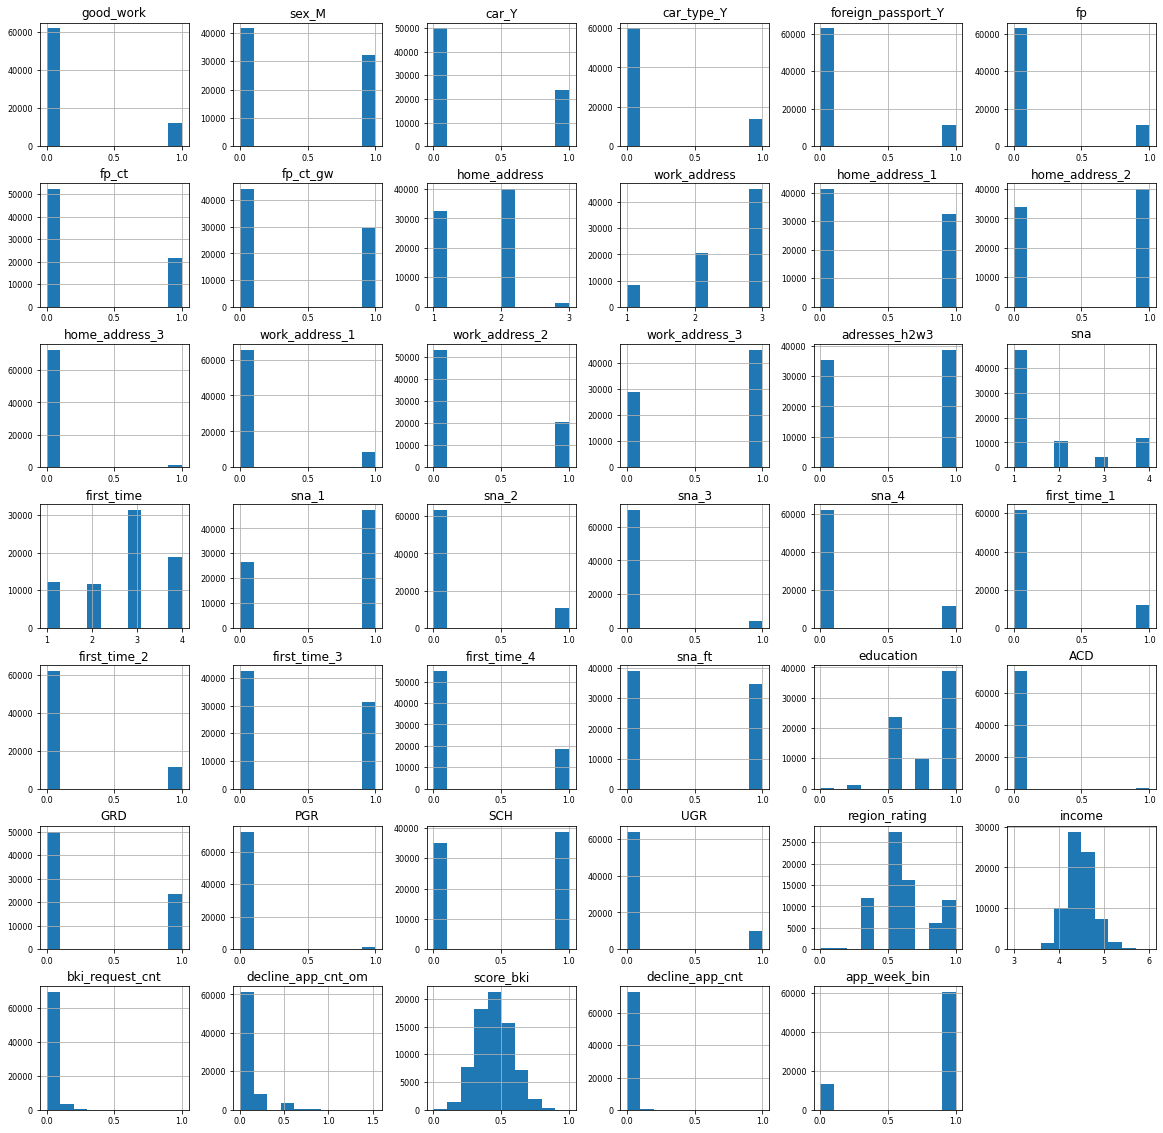

In [97]:
X.hist(xlabelsize=8, ylabelsize=8, figsize=(20, 20) )

In [98]:
y = train['default'].values



X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.25, random_state=42)
X_test.shape

(18450, 41)

In [99]:
np.unique(y_test, return_counts=True)
# .value_counts()

(array([0, 1], dtype=int64), array([16138,  2312], dtype=int64))

C:\Users\777\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


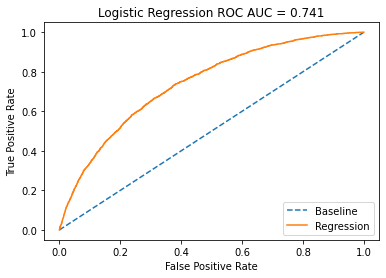

Accuracy: 0.8734
Precision: 0.4167
Recall: 0.0260
F1: 0.0489


In [100]:
lr = LogisticRegression(random_state=42 )
lr.fit(X_train, y_train)

probs = lr.predict_proba(X_test)
probs = probs[:,1]
# y_pred=lr.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
y_pred = lr.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

In [101]:
lr

LogisticRegression(random_state=42)

In [102]:
# confusion_matrix(y_test, probs, labels=[0, 1], normalize=True)

np.round(confusion_matrix(y_test, y_pred), 3)

array([[16054,    84],
       [ 2252,    60]], dtype=int64)

In [103]:
y.shape

(73799,)

In [104]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [105]:
import xgboost

Fitting 5 folds for each of 105 candidates, totalling 525 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 525 out of 525 | elapsed: 33.2min finished
C:\Users\777\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:32] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


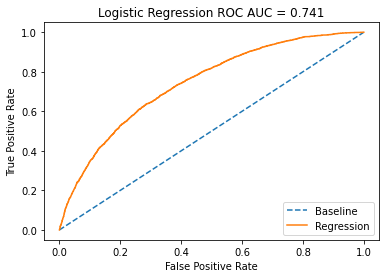

Accuracy: 0.8745
Precision: 0.4835
Recall: 0.0190
F1: 0.0366


In [106]:
model = xgboost.XGBClassifier(objective= 'binary:logistic',    nthread=4,    seed=42)


parameters = {
    'max_depth': range (2, 7, 1),
    'n_estimators': range(60, 200, 20),
    'learning_rate': [0.1, 0.01, 0.025]
}


grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 5,
    verbose=True
)


grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
probs = grid_search.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

In [107]:
confusion_matrix(y_test, y_pred)

array([[16091,    47],
       [ 2268,    44]], dtype=int64)

C:\Users\777\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:05] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


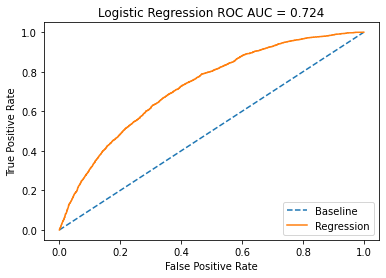

Accuracy: 0.8710
Precision: 0.3618
Recall: 0.0385
F1: 0.0696


In [108]:
model = xgboost.XGBClassifier(seed=42)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

In [109]:
confusion_matrix(y_test, y_pred)

array([[15981,   157],
       [ 2223,    89]], dtype=int64)

In [110]:
X_train.shape

(55349, 41)

In [111]:
# from sklearn.model_selection import GridSearchCV

# # Добавим типы регуляризации
# penalty = ['l1', 'l2']

# # Зададим ограничения для параметра регуляризации
# C = np.logspace(0, 4, 10)

# # Создадим гиперпараметры
# hyperparameters = dict(C=C, penalty=penalty)

# model = LogisticRegression()
# model.fit(X_train, y_train)

# # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
# clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

# best_model = clf.fit(X_train, y_train)

# # View best hyperparameters
# print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

In [112]:
LR = LogisticRegression(random_state=42)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(LR, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
LR = gridsearch.best_estimator_
##печатаем параметры
best_parameters = LR.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
y_pred = LR.predict(X_test)
y_prob = LR.predict_proba(X_test)
y_prob = y_prob[:,1]

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))
confusion_matrix( y_test, y_pred,  labels=[0, 1])

C:\Users\777\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: 42
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6702
Precision: 0.2275
Recall: 0.6808
F1: 0.3410


array([[10792,  5346],
       [  738,  1574]], dtype=int64)

In [113]:
np.round(confusion_matrix(y_test, y_pred, normalize='all'), 3)*100

array([[58.5, 29. ],
       [ 4. ,  8.5]])

In [114]:
confusion_matrix(y_test, y_pred)

array([[10792,  5346],
       [  738,  1574]], dtype=int64)